# Load package

In [1]:
%cd ..

C:\Users\LiuJinbao\Documents\Code\PlasmaChemistry_Copy


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["font.size"] = 15

In [6]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_ln_constructor, standard_Arr_constructor,
                           chemkin_Arr_2_rcnts_constructor,
                           chemkin_Arr_3_rcnts_constructor, eval_constructor,
                           reversed_reaction_constructor, alpha_constructor,
                           F_gamma_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [7]:
import yaml
yaml.add_constructor("!StandardArr", standard_Arr_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!ChemKinArr_2_rcnt", chemkin_Arr_2_rcnts_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!ChemKinArr_3_rcnt", chemkin_Arr_3_rcnts_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!rev", reversed_reaction_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!LT", LT_ln_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!alpha", alpha_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!F_gamma", F_gamma_constructor, Loader=yaml.FullLoader)

# variables from widgets

`_species_list`

`_init_yaml_file_path`

`_vari_dict`

`rctn_all [dict, ...]`
 - _electron reactions_
 - _relaxation reactions_
 - _chemical reactions_
 - decom_recom reactions

`rctn_df [dataframe, ...]` 
- _species_
- _electron_
- _chemical_
- decom_recom
- _relaxation_

`rctn_instances [Reactions instances, ...]`
- _cros reactions_
- _coef reactions_

In [8]:
_species_list = [
    'E', 'H2(v0-14)', 'CO2(va-d)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O',
    'H2(all)', 'CO2(all)', 'CO(all)','O2(all)','H2O(all)',
    'C', 'H', 'O', 'OH'
]
_species_group = {"H2(all)": ["H2"] + [f"H2(v{_})" for _ in range(1,15)],
                 "CO2(all)": ["CO2"] + [f"CO2(v{_})" for _ in range(1,22)] + \
                 ["CO2(va)", "CO2(vb)", "CO2(vc)", "CO2(vd)"]}
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                  H2_vib_energy_in_K=H2_vib_energy_in_K,
                  CO_vib_energy_in_eV=CO_vib_energy_in_eV,
                  CO_vib_energy_in_K=CO_vib_energy_in_K,
                  CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                  CO2_vib_energy_in_K=CO2_vib_energy_in_K)
# ---------------------------------------------------------------------------- #
rctn_all = {
    'global_abbr': None,
    'electron reactions': None,
    'relaxation reactions': None,
    'chemical reactions': None,
    'decom_recom reactions': None
}
with open(_init_yaml_file_path, 'r') as f:
    rctn_block = yaml.load(f, Loader=yaml.FullLoader)
rctn_all = rctn_block[-1]['The reactions considered']

global_abbr = rctn_all['global_abbr']

rctn_df = {
    'species': None,
    'electron': None,
    'chemical': None,
    'decom_recom': None,
    'relaxation': None
}
rctn_instances = {'cros reactions': None, 'coef reactions': None}

# widgets function
`yaml file` => `rctn_all` (dict inside)
            => `rctn_df` (dataframe insdie) 
            => `rctn_instances` (instances inside)
- `get_species_from_widgets`
- `get_rctn_df_from_widgets`
- `instance_dataframe`



In [9]:
def get_species_from_widgets(_event):
    with _widgets['output']:
        print('Get species from widgets ...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO2(va-d)':
            species.extend(['CO2(va)', 'CO2(vb)', 'CO2(vc)', 'CO2(vd)'])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(1, 11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    assert rctn_df['species'][0] == 'E'
    with _widgets['output']:
        print('DONE!')


def get_rctn_df_from_widgets(_event):
    with _widgets['output']:
        print('Get reaction dataframe from widgets ...', end=' ')
    rctn_df['electron'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['chemical'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['relaxation'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['decom_recom'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ------------------------------------------------------------------------ #
    #    rctn_df that is generated from the widgets and rctn_all.
    # ------------------------------------------------------------------------ #
    #   electron
    for _ in _widgets['electron'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        factor = 1
        rctn_df['electron'] = pd.concat([
            rctn_df['electron'],
            _cros_block.generate_crostn_dataframe(factor=factor)
        ],
                                        ignore_index=True,
                                        sort=False)

    # ------------------------------------------------------------------------ #
    #   relaxation
    for _ in _widgets['relaxation'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['relaxation'] = pd.concat(
            [rctn_df['relaxation'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #   chemical
    for _ in _widgets['chemical'].value:
        _df = rctn_all['chemical reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['chemical'] = pd.concat(
            [rctn_df['chemical'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #    decom_recom
    for _ in _widgets['decom_recom'].value:
        _df = rctn_all['decom_recom reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['decom_recom'] = pd.concat(
            [rctn_df['decom_recom'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)
    with _widgets['output']:
        print('DONE!')


# ---------------------------------------------------------------------------- #
def rctn_all_dict_keys_to_formulas(_key):
    _formula = _key.replace('_to_', ' => ')
    _formula = _formula.replace('_', ' + ')
    return _formula


# ---------------------------------------------------------------------------- #
def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


# ---------------------------------------------------------------------------- #
def instance_dataframe(_):
    with _widgets['output']:
        print("Get instance from rctn_df ...", end=' ')
    # ------------------------------------------------------------------------ #
    reactant, product = from_rctn_df_to_cros_instance(rctn_df['electron'])

    rctn_instances['cros reactions'] = CrosReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        dH_e=rctn_df["electron"]["threshold_eV"],
        k_str=None)
    rctn_instances['cros reactions']._set_species_group(_species_group)
    # ------------------------------------------------------------------------ #
    reactant, product, kstr = pd.Series(), pd.Series(), pd.Series()
    for _key in ['relaxation', 'chemical', 'decom_recom']:
        _r, _p, _k = from_rctn_df_to_coef_instance(rctn_df[_key])
        reactant = pd.concat([reactant, _r], ignore_index=True, sort=False)
        product = pd.concat([product, _p], ignore_index=True, sort=False)
        kstr = pd.concat([kstr, _k], ignore_index=True, sort=False)

    rctn_instances['coef reactions'] = CoefReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=kstr)
    rctn_instances['coef reactions']._set_species_group(_species_group)
    rctn_instances['coef reactions'].compile_k_str()
    # ------------------------------------------------------------------------ #
    with _widgets['output']:
        print('DONE!')


def clean_output(_):
    _widgets['output'].clear_output()

# Set widgets and display widgets

In [10]:
# ---------------------------------------------------------------------------- #
_widgets = dict()
# ---------------------------------------------------------------------------- #
#   Set SelectMultiple widgets
# ---------------------------------------------------------------------------- #
for _, _option, _height in [
    ('species', _species_list, '400px'),
    ('electron', rctn_all['electron reactions'].keys(), '150px'),
    ('relaxation', rctn_all['relaxation reactions'].keys(), '150px'),
    ('chemical', rctn_all['chemical reactions'].keys(), '400px'),
    ('decom_recom', rctn_all['decom_recom reactions'].keys(), '400px')
]:
    if _ in ('chemical', 'decom_recom'):
        show_option = [(rctn_all_dict_keys_to_formulas(_o), _o)
                       for _o in _option]
    else:
        show_option = _option
    _widgets[_] = widgets.SelectMultiple(options=show_option,
                                         value=list(_option),
                                         layout=Layout(height=_height,
                                                       width='300px'))

# ---------------------------------------------------------------------------- #
#   Set FloatText widgets
# ---------------------------------------------------------------------------- #
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# ---------------------------------------------------------------------------- #
#   Set Buttons
# ---------------------------------------------------------------------------- #
_button = dict()
_button['load reactions'] = widgets.Button(description='rctn_all => rctn_df')
_button['instance rctn_df'] = widgets.Button(description='=> rctn_instances')
_button['clean output'] = widgets.Button(description='clean output')

# ---------------------------------------------------------------------------- #
_widgets['output'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%'
})


# ---------------------------------------------------------------------------- #
#   Widgets display
# ---------------------------------------------------------------------------- #
def _label(_str):
    return widgets.HTML(f'<b>{_str}</b>')


widgets.Text()
display(
    widgets.HBox([
        widgets.HTML('<b>Yaml File Path</b>'),
        widgets.Text(value=_init_yaml_file_path, disabled=True)
    ],
                 layout=Layout(border='solid 2px', width='80%')))
display(
    widgets.HBox(
        [
            #1
            widgets.VBox([_label('SPECIES'), _widgets['species']]),
            #2
            widgets.VBox([
                _label('ELECTRON REACTIONS'), _widgets['electron'],
                _label('RELAXATION REACTIONS'), _widgets['relaxation']
            ]),
            #3
            widgets.VBox([_label('CHEMICAL REACTIONS'), _widgets['chemical']]),
            #4
            widgets.VBox(
                [_label('DECOM_RECOM REACTIONS'), _widgets['decom_recom']])
        ],
        layout=Layout(width='80%', border='solid 2px')))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)",
                        width='80%',
                        border='solid 2px')))
display(
    widgets.VBox([
        _button['load reactions'], _button['instance rctn_df'],
        _button['clean output']
    ],
                 layout=Layout(border='solid 2px',
                               display='flex',
                               align_items='stretch',
                               width='30%')))
display(_widgets['output'])
# ---------------------------------------------------------------------------- #
#   Widgets events
# ---------------------------------------------------------------------------- #
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['load reactions'].on_click(get_species_from_widgets)
_button['instance rctn_df'].on_click(instance_dataframe)
_button['clean output'].on_click(clean_output)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

Output(layout=Layout(border='2px solid blue', width='80%'))

# Prepare rctn_instances

In [11]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
rctn_instances['cros reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron'],
    electron_energy_grid=eedf.energy_point)

# Tgas function

In [12]:
# ---------------------------------------------------------------------------- #
#   sharp down
#   slow down
# ---------------------------------------------------------------------------- #
def Tgas_func_sharp_down(t, time_end, Tgas_arc):
    if t > time_end:
        return 300
    else:
        return Tgas_arc


def Tgas_func_slow_down(t, time_end, time_cold, Tgas_arc):
    if t > time_end:
        return (Tgas_arc - 300) * math.exp(-(t - time_end)**2 / 2 /
                                           (time_cold - time_end)**2) + 300
    else:
        return Tgas_arc

# electron density function

In [13]:
def electron_density_func(t, time_end, _density):
    if t > time_end:
        return 0
    else:
        return _density

# dndt functions

In [15]:
_widgets['Tgas_K_0'] = widgets.Text(description='init Tgas_K:', value='3000')
_widgets['Te_eV_0'] = widgets.Text(description='init Te_eV:', value='1.5')
_widgets['ne_0'] = widgets.Text(description='init ne', value='1e20')
_widgets['time_span'] = widgets.Text(description='Time span:',
                                     value='0, 1e-1',
                                     layout=Layout(width='200px'))
_widgets['atol'] = widgets.Text(description='atol:',
                                value='1e12',
                                layout=Layout(width='200px'))
_widgets['rtol'] = widgets.Text(description='rtol:',
                                value='1e-2',
                                layout=Layout(width='200px'))
display(_widgets['Tgas_K_0'])
display(_widgets['Te_eV_0'])
display(_widgets['ne_0'])
display(_widgets['time_span'])
display(_widgets['atol'])
display(_widgets['rtol'])

Text(value='3000', description='init Tgas_K:')

Text(value='1.5', description='init Te_eV:')

Text(value='1e20', description='init ne')

Text(value='0, 1e-1', description='Time span:', layout=Layout(width='200px'))

Text(value='1e12', description='atol:', layout=Layout(width='200px'))

Text(value='1e-2', description='rtol:', layout=Layout(width='200px'))

In [16]:
Tgas_0 = float(_widgets['Tgas_K_0'].value)
Te_eV = float(_widgets['Te_eV_0'].value)
ne_0 = float(_widgets['ne_0'].value)
_atol = float(_widgets['atol'].value)
_rtol = float(_widgets['rtol'].value)
print(f"Tgas: {Tgas_0: .0f} K \nTe_eV: {Te_eV: .1f} eV \nne_0: {ne_0: .2e} m-3")
print(f"atol: {_atol:.0e} \nrtol: {_rtol:.0e}")

Tgas:  3000 K 
Te_eV:  1.5 eV 
ne_0:  1.00e+20 m-3
atol: 1e+12 
rtol: 1e-02


In [17]:
def dndt_cros(t, density_without_e, _electron_density):
    _instance = rctn_instances['cros reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_coef(t, density_without_e, _electron_density, Tgas_K):
    _instance = rctn_instances['coef reactions']
    _instance.set_rate_const(Tgas_K=Tgas_K)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_all(t, y):
    
    _e_density = electron_density_func(t, time_end, ne_0)
    
    # _Tgas_K = Tgas_func_sharp_down(t, 1e-3, Tgas_0)
    _Tgas_K = Tgas_func_slow_down(t, time_end, time_cold, Tgas_0)
    print(f"t = {t:.6e} s    Tgas_K: {_Tgas_K:.0f} K, H2: {y[0]:.1e} CO2: {y[15]:.1e}")
    dydt = dndt_cros(t, y, _e_density) + dndt_coef(t, y, _e_density, _Tgas_K)
    return dydt[1:]


def dndt_all_with_Tgas(t, y):
    pass

In [18]:
H2_percent_seq = [
    0.9999, 0.93333, 0.88889, 0.83333, 0.77778, 0.66667, 0.5, 0.33333, 0.23077,
    0.16667, 0.13043, 0.09091, 0.07407, 0.0566, 0.03, 0.01, 0
]
time_end_seq = [
    0.38564, 0.46339, 0.58923, 0.66704, 0.69614, 0.8726, 0.97919, 1.01216,
    1.05427, 1.14294, 1.06026, 1.11772, 1.13853, 1.17361, 1.26435, 1.30063,
    1.27632
]
#### ====================
# i_index = 6 for H2/CO2 = 1:1
i_index = -1
H2_percent = H2_percent_seq[i_index]
time_end = time_end_seq[i_index] * 1e-3
#
# H2_percent = 0.0002
# time_end = 1e-3
time_cold = time_end + 2e-2
# time_end = 1e-3

In [19]:
# ---------------------------------------------------------------------------- #
density_0 = rctn_instances['cros reactions'].get_initial_density(
    density_dict={
        'CO2': 2.4e24 * (1 - H2_percent),
        'H2': 2.4e24 * H2_percent,
        'E': ne_0,
        'CO2(all)':2.4e24 * (1 - H2_percent),
        'H2(all)': 2.4e24 * H2_percent,
    })
density_without_e_0 = density_0[1:]
normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=Te_eV)

# Start evolution

In [20]:
sol = solve_ivp(
    dndt_all,
    [float(_.strip()) for _ in _widgets['time_span'].value.split(',')],
    density_without_e_0,
    method='BDF',
    atol=float(_widgets['atol'].value),
    rtol=float(_widgets['rtol'].value))
print("Solve Done!")

t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 5.551866e-27 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 6.8e+10
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.5e+04 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 

t = 2.537681e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+21
t = 3.012402e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 4.2e+21
t = 3.012402e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 4.2e+21
t = 3.487123e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 4.9e+21
t = 3.487123e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 4.9e+21
t = 3.961844e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 5.7e+21
t = 3.961844e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 5.7e+21
t = 4.436566e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 6.5e+21
t = 4.436566e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 6.5e+21
t = 5.497784e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 8.3e+21
t = 5.497784e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 8.3e+21
t = 6.559002e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 1.0e+22
t = 6.559002e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 1.0e+22
t = 7.620221e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 1.2e+22
t = 7.620221e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 1.2e+22
t = 8.681439e-16 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 

t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.5e+23
t = 3.662102e-14 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 

t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 3.0e+23
t = 6.355852e-13 s    Tgas_K: 3000 K, H2: 0.0e+00 CO2: 

t = 1.517250e-11 s    Tgas_K: 3000 K, H2: 1.4e-08 CO2: 3.0e+23
t = 1.781614e-11 s    Tgas_K: 3000 K, H2: 1.5e-08 CO2: 3.0e+23
t = 1.781614e-11 s    Tgas_K: 3000 K, H2: 1.1e-08 CO2: 3.0e+23
t = 2.501679e-11 s    Tgas_K: 3000 K, H2: 3.9e-08 CO2: 3.0e+23
t = 2.501679e-11 s    Tgas_K: 3000 K, H2: -2.6e-07 CO2: 3.0e+23
t = 2.501679e-11 s    Tgas_K: 3000 K, H2: -6.6e-08 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 1.3e-05 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 2.2e-01 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2: 3.0e+23
t = 3.221744e-11 s    Tgas_K: 3000 K, H2: 3.7e-07 CO2

t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 4.0e-07 CO2: 3.0e+23
t = 1.066270e-10 s    Tgas_K: 3000 K, H2: 5.8e-07 CO2: 3.0e+23
t = 1.330696e-10 s    Tgas_K: 3000 K, H2: 4.9e-07 CO2: 

t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 3.0e+23
t = 5.644004e-10 s    Tgas_K: 3000 K, H2: 1.1e-07 CO2: 

t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 3.0e+23
t = 2.423739e-09 s    Tgas_K: 3000 K, H2: 1.0e-08 CO2: 

t = 9.490394e-08 s    Tgas_K: 3000 K, H2: -2.3e-14 CO2: 2.7e+23
t = 1.018314e-07 s    Tgas_K: 3000 K, H2: 1.3e-12 CO2: 2.7e+23
t = 1.018314e-07 s    Tgas_K: 3000 K, H2: -4.9e-14 CO2: 2.7e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-13 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: -2.2e-01 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.4e+23
t = 1.711057e-07 s    Tgas_K: 3000 K, H2: 1.2e-12 CO

t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 2.7e+23
t = 1.022373e-07 s    Tgas_K: 3000 K, H2: 8.0e-15 CO2: 

t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 2.6e+23
t = 2.615547e-07 s    Tgas_K: 3000 K, H2: 3.4e-15 CO2: 

t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2: -1.4e-14 CO2: 2.1e+23
t = 2.640517e-06 s    Tgas_K: 3000 K, H2

t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 2.4e+23
t = 1.004346e-06 s    Tgas_K: 3000 K, H2: 6.0e-15 CO2: 

t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2: -6.4e-15 CO2: 5.3e+22
t = 8.870196e-06 s    Tgas_K: 3000 K, H2

t = 5.580479e-06 s    Tgas_K: 3000 K, H2: 9.0e-15 CO2: 1.3e+23
t = 5.580479e-06 s    Tgas_K: 3000 K, H2: 1.2e-14 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 5.7e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 2.2e-01 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.3e+23
t = 5.613180e-06 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 

t = 5.972891e-06 s    Tgas_K: 3000 K, H2: -2.9e-14 CO2: 1.3e+23
t = 6.299900e-06 s    Tgas_K: 3000 K, H2: 8.4e-15 CO2: 1.2e+23
t = 6.299900e-06 s    Tgas_K: 3000 K, H2: 3.5e-14 CO2: 1.2e+23
t = 7.285105e-06 s    Tgas_K: 3000 K, H2: 3.3e-15 CO2: 1.0e+23
t = 7.285105e-06 s    Tgas_K: 3000 K, H2: -2.5e-13 CO2: 1.0e+23
t = 8.270310e-06 s    Tgas_K: 3000 K, H2: 7.0e-15 CO2: 8.1e+22
t = 8.270310e-06 s    Tgas_K: 3000 K, H2: -6.3e-13 CO2: 8.1e+22
t = 8.270310e-06 s    Tgas_K: 3000 K, H2: -9.7e-14 CO2: 8.1e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-13 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 1.4e-12 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 4.1e-13 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-13 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-01 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-13 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-13 CO2: 5.4e+22
t = 9.631439e-06 s    Tgas_K: 3000 K, H2: 2.2e-13 C

t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.1e+22
t = 8.270344e-06 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 

t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 2.0e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: -2.2e-01 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2: 8.1e+22
t = 8.431850e-06 s    Tgas_K: 3000 K, H2: 1.3e-14 CO2:

t = 1.442606e-04 s    Tgas_K: 3000 K, H2: 6.6e-14 CO2: 1.2e+23
t = 1.442606e-04 s    Tgas_K: 3000 K, H2: 3.9e-13 CO2: 1.2e+23
t = 2.514018e-04 s    Tgas_K: 3000 K, H2: 8.1e-15 CO2: 1.5e+23
t = 2.514018e-04 s    Tgas_K: 3000 K, H2: 3.3e-13 CO2: 1.5e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 2.6e-13 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: -2.2e-01 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2: 2.1e+23
t = 4.687520e-04 s    Tgas_K: 3000 K, H2: 1.2e-12 CO2:

t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 1.5e+23
t = 2.514416e-04 s    Tgas_K: 3000 K, H2: 1.4e-13 CO2: 

t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2: -8.6e-13 CO2: 2.4e+23
t = 4.225519e-04 s    Tgas_K: 3000 K, H2

t = 5.321504e-04 s    Tgas_K: 3000 K, H2: 5.5e-14 CO2: 3.0e+23
t = 5.321504e-04 s    Tgas_K: 3000 K, H2: 2.3e-13 CO2: 3.1e+23
t = 5.321504e-04 s    Tgas_K: 3000 K, H2: 8.8e-14 CO2: 3.0e+23
t = 5.260616e-04 s    Tgas_K: 3000 K, H2: 5.9e-14 CO2: 3.0e+23
t = 5.260616e-04 s    Tgas_K: 3000 K, H2: 1.8e-14 CO2: 3.0e+23
t = 5.321504e-04 s    Tgas_K: 3000 K, H2: -5.4e-14 CO2: 3.1e+23
t = 5.321504e-04 s    Tgas_K: 3000 K, H2: -6.4e-14 CO2: 3.0e+23
t = 5.382392e-04 s    Tgas_K: 3000 K, H2: 9.1e-14 CO2: 3.1e+23
t = 5.382392e-04 s    Tgas_K: 3000 K, H2: 4.6e-14 CO2: 3.1e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.9e-14 CO2: 3.4e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.8e-11 CO2: 3.1e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.9e-14 CO2: 3.4e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: -2.2e-01 CO2: 3.4e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.9e-14 CO2: 3.4e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.9e-14 CO2: 3.4e+23
t = 5.834596e-04 s    Tgas_K: 3000 K, H2: 2.9e-14 CO

t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 6.5e-12 CO2: 4.2e+23
t = 6.906723e-04 s    Tgas_K: 3000 K, H2: 3.0e-13 CO2: 4.2e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -1.2e-12 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -3.0e-13 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: 6.0e-14 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: 4.7e-15 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -1.2e-12 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -2.2e-01 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -1.2e-12 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -1.2e-12 CO2: 4.6e+23
t = 7.526647e-04 s    Tgas_K: 3000 K, H2: -1.2e-1

t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 2.1e-14 CO2: 4.8e+23
t = 7.836609e-04 s    Tgas_K: 3000 K, H2: 9.5e-13 CO2: 4.8e+23
t = 8.597230e-04 s    Tgas_K: 3000 K, H2: -4.8e-12 CO2: 5.3e+23
t = 8.597230e-04 s    Tgas_K: 3000 K, H2: 1.5e-12 CO2: 5.3e+23
t = 8.597230e-04 s    Tgas_K: 3000 K, H2: -4.8e-12 CO2: 5.3e+23
t = 8.597230e-04 s    Tgas_K: 3000 K, H2: -2.2e-01 CO

t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 5.6e+23
t = 9.072619e-04 s    Tgas_K: 3000 K, H2: 9.7e-13 CO2: 

t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 7.9e-15 CO2: 6.9e+23
t = 1.097417e-03 s    Tgas_K: 3000 K, H2: 2.8e-13 CO2: 6.9e+23
t = 1.235991e-03 s    Tgas_K: 3000 K, H2: 2.1e-12 CO2: 7.8e+23
t = 1.235991e-03 s    Tgas_K: 3000 K, H2: -9.2e-13 CO2: 7.8e+23
t = 1.235991e-03 s    Tgas_K: 3000 K, H2: 2.1e-12 CO2: 7.8e+23
t = 1.235991e-03 s    Tgas_K: 3000 K, H2: 2.2e-01 CO2:

t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: -1.5e-12 CO2: 8.7e+23
t = 1.374565e-03 s    Tgas_K: 3000 K, H2: 2.4e-12 CO2: 8.7e+23
t = 1.305278e-03 s    Tgas_K: 3000 K, H2: -6.0e-13 CO2: 8.3e+23
t = 1.305278e-03 s    Tgas_K: 3000 K, H2: -3.8e-13 CO2: 8.3e+23
t = 1.305278e-03 s    Tgas_K: 3000 K, H2: 6.1e-14 CO2: 8.3e+23
t = 1.270634e-03 s    Tgas_K: 3000 K, H2: -2.5e-13 CO2: 8.0e+23
t = 1.270634e-03 s    Tgas_K: 3000 K, H2: 

t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 8.1e+23
t = 1.277710e-03 s    Tgas_K: 3000 K, H2: 2.5e-14 CO2: 

t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276464e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 

t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276338e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 

t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 

t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 8.1e+23
t = 1.276320e-03 s    Tgas_K: 3000 K, H2: 3.8e-14 CO2: 

t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 8.1e+23
t = 1.276323e-03 s    Tgas_K: 3000 K, H2: 3.7e-14 CO2: 

t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 1.0e+24
t = 2.578765e-03 s    Tgas_K: 2994 K, H2: 2.3e-12 CO2: 

t = 4.025268e-03 s    Tgas_K: 2975 K, H2: -2.2e-01 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2: 1.3e+24
t = 4.025268e-03 s    Tgas_K: 2975 K, H2: 4.6e-13 CO2:

t = 4.590351e-03 s    Tgas_K: 2963 K, H2: -1.2e-11 CO2: 1.3e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: -2.1e-13 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: -2.2e-01 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO2: 1.4e+24
t = 5.155434e-03 s    Tgas_K: 2950 K, H2: 2.4e-11 CO

t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2: -8.2e-12 CO2: 1.3e+24
t = 4.591248e-03 s    Tgas_K: 2963 K, H2

t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2: -3.8e-14 CO2: 2.1e+24
t = 8.178946e-03 s    Tgas_K: 2844 K, H2

t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 1.8e+24
t = 7.151445e-03 s    Tgas_K: 2886 K, H2: 7.5e-15 CO2: 

t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 2.2e+24
t = 7.179062e-03 s    Tgas_K: 2885 K, H2: 8.3e-15 CO2: 

t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -2.2e-01 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2: -5.7e-14 CO2: 3.8e+24
t = 7.325712e-03 s    Tgas_K: 2879 K, H2

t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: 3.4e-16 CO2: 3.8e+24
t = 7.321938e-03 s    Tgas_K: 2879 K, H2: -2.8e-13 CO2: 3.8e+24
t = 7.362212e-03 s    Tgas_K: 2878 K, H2: -1.3e-12 CO2: 4.3e+24
t = 7.362212e-03 s    Tgas_K: 2878 K, H2: 9.2e-14 CO2

t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: 1.3e-12 CO2: 6.8e+24
t = 7.587559e-03 s    Tgas_K: 2869 K, H2: -5.2e-13 CO2: 6.8e+24
t = 7.531222e-03 s    Tgas_K: 2871 K, H2: 8.2e-13 CO2: 6.1e+24
t = 7.531222e-03 s    Tgas_K: 2871 K, H2: 4.6e-13 CO2: 6.2e+24
t = 7.503054e-03 s    Tgas_K: 2872 K, H2: 6.8e-13 CO2: 5.8e+24
t = 7.503054e-03 s    Tgas_K: 2872 K, H2: 4.1e-14 CO2: 5.8e+24
t = 7.488970e-03 s    Tgas_K: 2873 K, H2: 6.4e-13 CO2: 5.7e+24
t = 7.488970e-03 s    Tgas_K: 2873 K, H2: -1.6e-13 CO2: 5.7e+24
t = 7.481927e-03 s    Tgas_K: 2873 K, H2: 6.2e-13 CO2

t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 6.4e+24
t = 7.544517e-03 s    Tgas_K: 2871 K, H2: 7.7e-14 CO2: 

t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 6.0e+24
t = 7.525488e-03 s    Tgas_K: 2871 K, H2: 1.8e-14 CO2: 

t = 7.527980e-03 s    Tgas_K: 2871 K, H2: -4.2e-15 CO2: 5.5e+24
t = 7.527847e-03 s    Tgas_K: 2871 K, H2: -3.3e-16 CO2: 5.6e+24
t = 7.527847e-03 s    Tgas_K: 2871 K, H2: 4.5e-16 CO2: 5.6e+24
t = 7.527780e-03 s    Tgas_K: 2871 K, H2: -2.8e-16 CO2: 5.6e+24
t = 7.527780e-03 s    Tgas_K: 2871 K, H2: 7.5e-16 CO2: 5.6e+24
t = 7.527747e-03 s    Tgas_K: 2871 K, H2: -2.5e-16 CO2: 5.6e+24
t = 7.527747e-03 s    Tgas_K: 2871 K, H2: -2.9e-16 CO2: 5.6e+24
t = 7.527730e-03 s    Tgas_K: 2871 K, H2: -2.3e-16 CO2: 5.6e+24
t = 7.527730e-03 s    Tgas_K: 2871 K, H2: 7.0e-17 CO2: 5.6e+24
t = 7.527747e-03 s    Tgas_K: 2871 K, H2: -8.1e-16 CO2: 5.6e+24
t = 7.527747e-03 s    Tgas_K: 2871 K, H2: 5.1e-19 CO2: 5.6e+24
t = 7.527764e-03 s    Tgas_K: 2871 K, H2: 1.2e-15 CO2: 5.6e+24
t = 7.527764e-03 s    Tgas_K: 2871 K, H2: 2.8e-16 CO2: 5.6e+24
t = 7.527930e-03 s    Tgas_K: 2871 K, H2: 2.8e-15 CO2: 5.5e+24
t = 7.527930e-03 s    Tgas_K: 2871 K, H2: 8.1e-15 CO2: 5.5e+24
t = 7.527930e-03 s    Tgas_K: 2871 K, H2: 2.8e-1

t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2: -4.4e-15 CO2: 4.5e+24
t = 7.531434e-03 s    Tgas_K: 2871 K, H2

t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 4.0e+24
t = 7.533102e-03 s    Tgas_K: 2871 K, H2: 3.4e-17 CO2: 

t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 1.6e+24
t = 7.541570e-03 s    Tgas_K: 2871 K, H2: 3.9e-15 CO2: 

t = 7.539811e-03 s    Tgas_K: 2871 K, H2: -6.3e-14 CO2: 2.1e+24
t = 7.539811e-03 s    Tgas_K: 2871 K, H2: -6.3e-14 CO2: 2.1e+24
t = 7.539811e-03 s    Tgas_K: 2871 K, H2: -2.5e-14 CO2: 2.1e+24
t = 7.538760e-03 s    Tgas_K: 2871 K, H2: -3.5e-14 CO2: 2.4e+24
t = 7.538760e-03 s    Tgas_K: 2871 K, H2: 1.1e-14 CO2: 2.4e+24
t = 7.539811e-03 s    Tgas_K: 2871 K, H2: 2.9e-15 CO2: 2.1e+24
t = 7.539811e-03 s    Tgas_K: 2871 K, H2: -1.6e-14 CO2: 2.1e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: 3.7e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: 2.2e-01 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1.8e-14 CO2: 1.3e+24
t = 7.542628e-03 s    Tgas_K: 2871 K, H2: -1

t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: -5.2e-14 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 1.4e-13 CO2: 8.3e+23
t = 7.546818e-03 s    Tgas_K: 2871 K, H2:

t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 8.3e+23
t = 7.544371e-03 s    Tgas_K: 2871 K, H2: 7.5e-15 CO2: 

t = 7.544469e-03 s    Tgas_K: 2871 K, H2: 7.8e-16 CO2: 8.3e+23
t = 7.544469e-03 s    Tgas_K: 2871 K, H2: 5.7e-16 CO2: 8.3e+23
t = 7.544436e-03 s    Tgas_K: 2871 K, H2: 6.5e-16 CO2: 8.3e+23
t = 7.544436e-03 s    Tgas_K: 2871 K, H2: -1.8e-15 CO2: 8.3e+23
t = 7.544419e-03 s    Tgas_K: 2871 K, H2: 5.9e-16 CO2: 8.3e+23
t = 7.544419e-03 s    Tgas_K: 2871 K, H2: -1.2e-17 CO2: 8.3e+23
t = 7.544410e-03 s    Tgas_K: 2871 K, H2: 5.6e-16 CO2: 8.3e+23
t = 7.544410e-03 s    Tgas_K: 2871 K, H2: 5.7e-16 CO2: 8.3e+23
t = 7.544419e-03 s    Tgas_K: 2871 K, H2: 6.2e-16 CO2: 8.3e+23
t = 7.544419e-03 s    Tgas_K: 2871 K, H2: 4.9e-16 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 1.7e-15 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 6.8e-16 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 1.7e-15 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 2.2e-01 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 1.7e-15 CO2: 8.3e+23
t = 7.544503e-03 s    Tgas_K: 2871 K, H2: 1.7e-15 CO2

t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2: -3.1e-14 CO2: 1.3e+24
t = 7.563136e-03 s    Tgas_K: 2870 K, H2

t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 1.6e+24
t = 7.575814e-03 s    Tgas_K: 2869 K, H2: 1.2e-15 CO2: 

t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2: -3.4e-14 CO2: 3.0e+24
t = 7.633530e-03 s    Tgas_K: 2867 K, H2

t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 5.9e+24
t = 7.750249e-03 s    Tgas_K: 2862 K, H2: 4.4e-13 CO2: 

t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 1.4e+25
t = 8.048848e-03 s    Tgas_K: 2850 K, H2: 1.5e-11 CO2: 

t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 2.9e+25
t = 8.536694e-03 s    Tgas_K: 2828 K, H2: 1.1e-12 CO2: 

t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -1.1e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: 2.2e-01 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2: -4.7e-10 CO2: 3.8e+25
t = 8.788756e-03 s    Tgas_K: 2816 K, H2:

t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2: -1.4e+04 CO2: 3.4e+25
t = 8.662732e-03 s    Tgas_K: 2822 K, H2

t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 3.1e+25
t = 8.665432e-03 s    Tgas_K: 2822 K, H2: 1.8e+00 CO2: 

t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2: -4.8e+03 CO2: 2.8e+25
t = 8.668950e-03 s    Tgas_K: 2822 K, H2

t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2: -1.7e+02 CO2: 2.7e+25
t = 8.670390e-03 s    Tgas_K: 2822 K, H2

t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2: -5.5e+03 CO2: 2.6e+25
t = 8.672143e-03 s    Tgas_K: 2822 K, H2

t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 2.7e+25
t = 8.670703e-03 s    Tgas_K: 2822 K, H2: 5.3e+03 CO2: 

t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 2.7e+25
t = 8.672580e-03 s    Tgas_K: 2822 K, H2: 9.4e+01 CO2: 

t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 2.9e+25
t = 8.688108e-03 s    Tgas_K: 2821 K, H2: 1.7e+01 CO2: 

t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 3.2e+25
t = 8.722496e-03 s    Tgas_K: 2819 K, H2: 5.8e+03 CO2: 

t = 8.736389e-03 s    Tgas_K: 2819 K, H2: -3.4e+06 CO2: 3.2e+25
t = 8.736389e-03 s    Tgas_K: 2819 K, H2: -8.4e+05 CO2: 3.2e+25
t = 8.736282e-03 s    Tgas_K: 2819 K, H2: -3.3e+06 CO2: 3.2e+25
t = 8.736282e-03 s    Tgas_K: 2819 K, H2: -6.9e+05 CO2: 3.2e+25
t = 8.736389e-03 s    Tgas_K: 2819 K, H2: 7.0e+06 CO2: 3.2e+25
t = 8.736389e-03 s    Tgas_K: 2819 K, H2: 2.1e+06 CO2: 3.2e+25
t = 8.736496e-03 s    Tgas_K: 2819 K, H2: -2.2e+06 CO2: 3.2e+25
t = 8.736496e-03 s    Tgas_K: 2819 K, H2: -7.8e+05 CO2: 3.2e+25
t = 8.737210e-03 s    Tgas_K: 2819 K, H2: -5.7e+06 CO2: 3.3e+25
t = 8.737210e-03 s    Tgas_K: 2819 K, H2: -2.6e+06 CO2: 3.3e+25
t = 8.737924e-03 s    Tgas_K: 2818 K, H2: -2.1e+06 CO2: 3.3e+25
t = 8.737924e-03 s    Tgas_K: 2818 K, H2: -1.3e+06 CO2: 3.3e+25
t = 8.743584e-03 s    Tgas_K: 2818 K, H2: 2.5e+06 CO2: 3.4e+25
t = 8.743584e-03 s    Tgas_K: 2818 K, H2: 2.6e+06 CO2: 3.4e+25
t = 8.743584e-03 s    Tgas_K: 2818 K, H2: 4.7e+06 CO2: 3.4e+25
t = 8.743584e-03 s    Tgas_K: 2818 K, H2: 9.3

t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2: -7.0e+07 CO2: 3.6e+25
t = 8.756698e-03 s    Tgas_K: 2818 K, H2

t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 3.6e+25
t = 8.756726e-03 s    Tgas_K: 2818 K, H2: 1.1e+06 CO2: 

t = 8.774886e-03 s    Tgas_K: 2817 K, H2: -8.5e+00 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 5.9e+01 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2: 4.0e+25
t = 8.774886e-03 s    Tgas_K: 2817 K, H2: 1.2e+02 CO2:

t = 8.788019e-03 s    Tgas_K: 2816 K, H2: -1.0e+03 CO2: 4.3e+25
t = 8.788019e-03 s    Tgas_K: 2816 K, H2: -1.6e+03 CO2: 4.3e+25
t = 8.807018e-03 s    Tgas_K: 2815 K, H2: 4.1e+03 CO2: 4.7e+25
t = 8.807018e-03 s    Tgas_K: 2815 K, H2: 8.1e+03 CO2: 4.7e+25
t = 8.807018e-03 s    Tgas_K: 2815 K, H2: 1.1e+03 CO2: 4.7e+25
t = 8.807018e-03 s    Tgas_K: 2815 K, H2: 1.5e+02 CO2: 4.7e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -2.0e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1.9e+03 CO2: 5.1e+25
t = 8.826016e-03 s    Tgas_K: 2814 K, H2: -1

t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 7.7e+04 CO2: 6.2e+25
t = 8.879232e-03 s    Tgas_K: 2812 K, H2: 1.5e+04 CO2: 6.2e+25
t = 8.913449e-03 s    Tgas_K: 2810 K, H2: -1.3e+04 CO2: 6.9e+25
t = 8.913449e-03 s    Tgas_K: 2810 K, H2: 1.4e+04 CO2: 6.9e+25
t = 8.947666e-03 s    Tgas_K: 2809 K, H2: 5.3e+03 CO2: 7.6e+25
t = 8.947666e-03 s    Tgas_K: 2809 K, H2: 9.1e+03 CO2: 7.6e+25
t = 8.947666e-03 s    Tgas_K: 2809 K, H2: 2.6e+02 CO2: 7.6e+25
t = 9.003969e-03 s    Tgas_K: 2806 K, H2: -7.3e+03 CO2: 8.8e+25
t = 9.003969e-03 s    Tgas_K: 2806 K, H2: 1.0e+04 CO2: 8.8e+25
t = 9.003969e-03 s    Tgas_K: 2806 K, H2: -3.9e+03 CO

t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 1.4e+26
t = 9.269861e-03 s    Tgas_K: 2793 K, H2: 2.1e+04 CO2: 

t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 1.1e+26
t = 9.116575e-03 s    Tgas_K: 2800 K, H2: 3.3e+03 CO2: 

t = 9.116582e-03 s    Tgas_K: 2800 K, H2: -9.3e+03 CO2: 1.1e+26
t = 9.116582e-03 s    Tgas_K: 2800 K, H2: 5.1e+03 CO2: 1.1e+26
t = 9.116614e-03 s    Tgas_K: 2800 K, H2: -2.6e+04 CO2: 1.2e+26
t = 9.116614e-03 s    Tgas_K: 2800 K, H2: -3.9e+03 CO2: 1.2e+26
t = 9.116646e-03 s    Tgas_K: 2800 K, H2: 5.8e+03 CO2: 1.3e+26
t = 9.116646e-03 s    Tgas_K: 2800 K, H2: 5.1e+04 CO2: 1.3e+26
t = 9.116772e-03 s    Tgas_K: 2800 K, H2: -7.9e+04 CO2: 1.7e+26
t = 9.116772e-03 s    Tgas_K: 2800 K, H2: -5.7e+04 CO2: 1.7e+26
t = 9.116899e-03 s    Tgas_K: 2800 K, H2: 1.3e+05 CO2: 2.1e+26
t = 9.116899e-03 s    Tgas_K: 2800 K, H2: -2.8e+05 CO2: 2.1e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: 2.4e+06 CO2: 2.9e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: -6.6e+06 CO2: 2.9e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: 2.4e+06 CO2: 2.9e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: 2.4e+06 CO2: 2.9e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: 2.4e+06 CO2: 2.9e+26
t = 9.117169e-03 s    Tgas_K: 2800 K, H2: 2.4e+0

t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 7.3e+26
t = 9.118687e-03 s    Tgas_K: 2800 K, H2: 3.1e+06 CO2: 

t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 4.6e+26
t = 9.117751e-03 s    Tgas_K: 2800 K, H2: 4.6e+02 CO2: 

t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 1.0e+27
t = 9.119581e-03 s    Tgas_K: 2800 K, H2: 1.1e+00 CO2: 

t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -1.8e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2: -2.0e+00 CO2: 3.6e+27
t = 9.128192e-03 s    Tgas_K: 2800 K, H2

t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 2.9e+27
t = 9.125976e-03 s    Tgas_K: 2800 K, H2: 5.5e+05 CO2: 

t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 2.9e+27
t = 9.125987e-03 s    Tgas_K: 2800 K, H2: 2.0e+09 CO2: 

t = 9.125981e-03 s    Tgas_K: 2800 K, H2: 2.2e+06 CO2: 2.9e+27
t = 9.125981e-03 s    Tgas_K: 2800 K, H2: 4.3e+06 CO2: 2.9e+27
t = 9.125981e-03 s    Tgas_K: 2800 K, H2: 1.8e+06 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 2.2e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 2.6e+06 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.1e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 5.4e+06 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.5e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 1.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.8e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 1.7e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.9e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 2.5e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.9e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 3.1e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 2.9e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.0e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.2e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 3.3e+27
t = 9.125980e-03 s    Tgas_K: 2800 K, H2: 4.0e+07 CO2: 

# Plot results

fig, ax = plt.subplots()
_Tgas = [Tgas_func_slow_down(_, 1e-3, 2e-3, Tgas_0) for _ in sol.t]
_e_density = [electron_density_func(_, 1e-3, ne_0) for _ in sol.t]
ax.semilogx(sol.t, _Tgas, marker='.')
ax_right = ax.twinx()
ax_right.plot(sol.t, _e_density, marker='.', color='red')

In [21]:
_CO2_group = ['CO2'] + [f"CO2(v{_})" for _ in range(1, 22)]
_CO2_group_all = _CO2_group + ['CO2(va)', 'CO2(vb)', 'CO2(vc)', 'CO2(vd)']
_H2_group = ['H2'] + [f"H2(v{_})" for _ in range(1, 15)]
_CO_group = ['CO'] + [f"CO(v{_})" for _ in range(1, 11)]
density_result = np.vstack(
    [[electron_density_func(_, time_end, ne_0) for _ in sol.t], sol.y])
density_result_df = pd.DataFrame(
    density_result, index=rctn_instances['cros reactions'].species)
densities = dict()

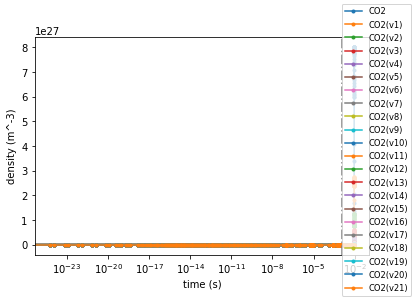

In [22]:
# ---------------------------------------------------------------------------- #
#   Plot CO2 vdf
# ---------------------------------------------------------------------------- #
%matplotlib inline
fig, ax = plt.subplots()
for _ in ['CO2'] + [f"CO2(v{_})" for _ in range(1,22)]:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    elif _ == 'CO_total':
        densities[_] = density_result_df.loc[_CO_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _].transpose()
    ax.semilogx(sol.t, densities[_], marker='.', label=_)
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
ax.axvline(time_end, color='gray', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')

In [23]:
density_result_df.loc[_CO2_group_all,:]

,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,525,526,527,528,529,530
CO2,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.400000e+24,2.399998e+24,...,6.849511e+27,6.759392e+27,6.663683e+27,6.562325e+27,6.455329e+27,6.291662e+27,6.202354e+27,6.109797e+27,6.055483e+27,6.000487e+27
CO2(v1),0.000000e+00,1.412587e+14,2.825174e+14,1.695105e+15,3.107692e+15,1.723356e+16,3.135943e+16,1.726181e+17,3.138766e+17,1.726455e+18,...,2.645760e+27,2.657971e+27,2.670271e+27,2.682500e+27,2.694480e+27,2.710844e+27,2.718737e+27,2.726113e+27,2.730045e+27,2.733711e+27
CO2(v2),0.000000e+00,4.701366e+05,9.567435e+05,7.273139e+06,1.524057e+07,2.399539e+08,6.297718e+08,1.903183e+10,5.394432e+10,1.853441e+12,...,1.032632e+27,1.056109e+27,1.081248e+27,1.108064e+27,1.136553e+27,1.180392e+27,1.204408e+27,1.229337e+27,1.243969e+27,1.258769e+27
CO2(v3),0.000000e+00,2.719248e+05,5.438496e+05,3.263098e+06,5.982346e+06,3.317483e+07,6.036731e+07,3.322948e+08,6.042278e+08,3.326310e+09,...,4.074358e+26,4.242282e+26,4.426329e+26,4.627587e+26,4.847155e+26,5.197063e+26,5.395167e+26,5.605817e+26,5.731906e+26,5.861372e+26
CO2(v4),0.000000e+00,7.035442e-05,2.220469e-04,8.901396e-03,2.573437e-02,9.103375e-01,2.610308e+00,9.123782e+01,2.614037e+02,9.131607e+03,...,1.624712e+26,1.722313e+26,1.831489e+26,1.953477e+26,2.089636e+26,2.313189e+26,2.443301e+26,2.584448e+26,2.670307e+26,2.759541e+26
CO2(v5),0.000000e+00,9.289041e-08,2.931731e-07,1.175272e-05,3.397773e-05,1.201964e-03,3.446550e-03,1.204892e-01,3.452397e-01,1.207559e+01,...,6.545227e+25,7.064447e+25,7.656754e+25,8.332372e+25,9.103115e+25,1.040505e+26,1.118288e+26,1.204279e+26,1.257386e+26,1.313212e+26
CO2(v6),0.000000e+00,5.272048e-08,1.663921e-07,6.670312e-06,1.928420e-05,6.821669e-04,1.956050e-03,6.836951e-02,1.958835e-01,6.838726e+00,...,2.662430e+25,2.926017e+25,3.232584e+25,3.589445e+25,4.005376e+25,4.727875e+25,5.170716e+25,5.669422e+25,5.982008e+25,6.314278e+25
CO2(v7),0.000000e+00,2.945456e-08,9.296208e-08,3.726657e-06,1.077395e-05,3.811219e-04,1.092832e-03,3.819757e-02,1.094388e-01,3.820748e+00,...,1.092862e+25,1.223042e+25,1.377397e+25,1.560737e+25,1.779029e+25,2.168906e+25,2.414005e+25,2.695137e+25,2.873947e+25,3.066122e+25
CO2(v8),0.000000e+00,1.634988e-08,5.160216e-08,2.068623e-06,5.980492e-06,2.115563e-04,6.066180e-04,2.120302e-02,6.074817e-02,2.120851e+00,...,4.523528e+24,5.155451e+24,5.919331e+24,6.845126e+24,7.971164e+24,1.003904e+25,1.137226e+25,1.292978e+25,1.393497e+25,1.502724e+25
CO2(v9),0.000000e+00,9.025389e-09,2.848520e-08,1.141912e-06,3.301324e-06,1.167824e-04,3.348626e-04,1.170440e-02,3.353393e-02,1.170742e+00,...,1.886612e+24,2.189900e+24,2.563695e+24,3.025962e+24,3.600356e+24,4.685068e+24,5.402295e+24,6.255734e+24,6.814625e+24,7.428666e+24


In [24]:
CO2_normal_vdf = (density_result_df.loc[_CO2_group_all,:].values/density_result_df.loc['CO2',:].values).transpose()
CO2_normal_vdf.shape
sol.t.transpose().shape

(531,)

In [25]:
np.savetxt('_output/CO2_vdf.txt', np.vstack((sol.t,CO2_normal_vdf.transpose())).transpose())

FileNotFoundError: [Errno 2] No such file or directory: '_output/CO2_vdf.txt'

In [26]:
for _ in sol.t:
#     print(_, end=' ')
    print(Tgas_func_slow_down(_, time_end, time_end+4e-3, Tgas_0))
#     print(electron_density_func(_, time_end, 1e20))

3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0

## reaction info

In [27]:
print(H2_percent)
print(H2_percent/(1-H2_percent))
print("H O OH")
print(
    f"{density_result_df.loc['H'].max():.1e} {density_result_df.loc['O'].max():.1e} {density_result_df.loc['OH'].max():.1e} "
)
print(f"CO max: {density_result_df.loc[_CO_group, :].sum().values.max():.3e}")
print(f"CO output: {density_result_df.loc['CO'].values[-1]:.1e}")

0
0.0
H O OH
5.4e+13 1.0e+23 3.7e+07 
CO max: 5.113e+24
CO output: 1.7e+24


In [ ]:
density_result_df.loc[_CO_group, :].sum().values[-1]

In [ ]:
density_result_df.loc[_CO_group, :].sum().values.max()

In [ ]:
plt.semilogx(sol.t, density_result_df.loc['CO2(all)'])
plt.semilogx(sol.t, density_result_df.loc[_CO2_group_all].sum())

## show vdf

In [ ]:
# _widgets['plot_vdf'] = widgets.FloatLogSlider(value=sol.t[1], min=sol.t[1], max=sol.t[-1],step=1)
_widgets['plot_vdf'] = widgets.FloatLogSlider(value=math.log10(sol.t[1]),
                                              min=math.log10(sol.t[1]),
                                              max=math.log10(sol.t[-1]),
                                              step=0.0001,
                                              description='Time (s):')

_widgets['output_rctn'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%',
    'height': '350px'
})

display(_widgets['output_rctn'])
display(_widgets['plot_vdf'])
_df_show_vdf = pd.Series(index=rctn_instances['cros reactions'].species)

_interp_result = interp1d(sol.t, density_result)


def get_CO2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_CO2_group].values


def get_H2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_H2_group].values

# ---------------------------------------------------------------------------- #
#   plot main molecule
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
output_evolution = [sol.t]
for _ in ['CO2_total', 'H2_total', 'CO_total', 'H2O', 'O2', 'H', 'O', 'OH', 'C']:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group_all, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    elif _ == 'CO_total':
        densities[_] = density_result_df.loc[_CO_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _][0]
    line_species, = ax.semilogx(sol.t, densities[_], marker='.', label=_)
    output_evolution.append(densities[_])
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
vline_time_end = ax.axvline(time_end, color='gray', linestyle='-')
vline = ax.axvline(time_end, color='black', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')
# ---------------------------------------------------------------------------- #
#   plot the vdf
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
line_CO2_vdf, = ax.semilogy(list(range(22)), get_CO2_vdf_at_time(0), marker='.',label='CO2')
line_H2_vdf, = ax.semilogy(list(range(15)), get_H2_vdf_at_time(0), marker='.', label='H2')
# ax.set_title('CO2 density vs. v')
ax.set_xlabel('vibrational number')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right')
# ax.set_title('H2 density vs. v')
# ax.set_xlabel('H2_vdf')
# ax.set_ylabel('density')


def plot_CO2_vdf(change):
    _t = change['new']
    _ydata = get_CO2_vdf_at_time(_t)
    line_CO2_vdf.set_ydata(_ydata)
    ax.set_ylim(_ydata.max()*1e-30, _ydata.max())


def plot_H2_vdf(change):
    _t = change['new']
    line_H2_vdf.set_ydata(get_H2_vdf_at_time(_t))

def CO2_consume_regexp_match(_str):
    rcnt, prdt = _str.split('=>')
    if rcnt.count('CO2') > prdt.count('CO2'):
        return True
    else:
        return False

def CO2_produce_regexp_match(_str):
    rcnt, prdt = _str.split('=>')
    if rcnt.count('CO2') < prdt.count('CO2'):
        return True
    else:
        return False
    
def show_top_reactions(change):
    # _formula_regexp = "(.*\s+)?O\s+.*=>.*"
    regexp_match = CO2_produce_regexp_match
    _t = change['new']
    _Tgas = Tgas_func_slow_down(_t, time_end, time_cold, Tgas_0)
    rctn_instances['coef reactions'].set_rate_const(Tgas_K=_Tgas)
    rctn_instances['coef reactions'].set_rate(density=_interp_result(_t))
    rctn_instances['cros reactions'].set_rate(density=_interp_result(_t))
    _df_coef = rctn_instances['coef reactions'].view_rate_const_and_rate()
    _df_cros = rctn_instances['cros reactions'].view_rate_const_and_rate()
    # _df_coef = _df_coef[_df_coef['formula'].map(CO2_consume_regexp_match)]
    # _df = _df[_df['formula'].str.match(_formula_regexp)]
    
    # _df_cros = _df_cros[_df_cros['formula'].map(CO2_consume_regexp_match)]
    _df = pd.concat([_df_cros, _df_coef], ignore_index=True)
    
    _df = _df[_df['formula'].map(regexp_match)]
    _df = _df.sort_values(by='rate', ascending=False)
    _widgets['output_rctn'].clear_output()
    vline.set_xdata(_t)
    with _widgets['output_rctn']:
        print(_df.head(n=20))
    
_widgets['plot_vdf'].observe(plot_CO2_vdf, names='value')
_widgets['plot_vdf'].observe(plot_H2_vdf, names='value')
_widgets['plot_vdf'].observe(show_top_reactions, names='value')

In [ ]:
# _formula_regexp = "(.*\s+)?O\s+.*=>.*"
# regexp_match = CO2_produce_regexp_match
_rate_consume_total = []
_rate_produce_total = []
_electron_energy_loss = []
for i, _t in enumerate(sol.t):
    print(i)
    _Tgas = Tgas_func_slow_down(_t, time_end, time_cold, Tgas_0)
    rctn_instances['coef reactions'].set_rate_const(Tgas_K=_Tgas)
    rctn_instances['coef reactions'].set_rate(density=_interp_result(_t))
    rctn_instances['cros reactions'].set_rate(density=_interp_result(_t))
    _df_coef = rctn_instances['coef reactions'].view_rate_const_and_rate()
    
    _df_cros = rctn_instances['cros reactions'].view_rate_const_and_rate()
    _electron_energy_loss.append((rctn_instances["cros reactions"].dH_e * rctn_instances["cros reactions"].rate).tolist())
    # _df_cros["dH_e_rate_const"] = rctn_instances["cros reactions"].get_dH_e()
    # _df_coef = _df_coef[_df_coef['formula'].map(CO2_consume_regexp_match)]
    # _df = _df[_df['formula'].str.match(_formula_regexp)]

    # _df_cros = _df_cros[_df_cros['formula'].map(CO2_consume_regexp_match)]
    _df = pd.concat([_df_cros, _df_coef], ignore_index=True)

    _rate_consume = [
        _df[_df['formula'].str.match(r"E \+ CO2.* => E \+ CO \+ O")]
        ['rate'].sum(), _df[_df['formula'].str.match(
            r"CO2.* \+ \S* => CO \+ O \S*")]['rate'].sum(),
        _df[_df['formula'].str.match(r"CO2.* \+ H => CO \+ OH")]['rate'].sum(),
        _df[_df['formula'].str.match(r"CO2.* \+ O => CO \+ O2")]['rate'].sum()
    ]
    _rate_produce = [_df[_df['formula'].str.match(r"CO \+ O .* => CO2.* \+ .*")]['rate'].sum(),
                     _df[_df['formula'].str.match(r"CO \+ OH => CO2.* \+ H")]['rate'].sum(),
                     _df[_df['formula'].str.match(r"CO \+ O2 => CO2.* \+ O")]['rate'].sum()
    ]
    _rate_consume_total.append(_rate_consume)
    _rate_produce_total.append(_rate_produce)

    # _df = _df[_df['formula'].map(regexp_match)]
_rate_consume_total = np.array(_rate_consume_total)
_rate_produce_total = np.array(_rate_produce_total)
_electron_energy_loss = np.array(_electron_energy_loss).transpose()

In [ ]:
_electron_energy_loss_vib_exc = _electron_energy_loss[0:78,:].sum(axis=0) + _electron_energy_loss[92:398,:].sum(axis=0) + \
_electron_energy_loss[424:478,:].sum(axis=0)
_electron_energy_loss_dis_exc = _electron_energy_loss.sum(axis=0)-_electron_energy_loss_vib_exc

In [ ]:
for i, _ in enumerate(sol.t):
    print(_ ,end=' ')
    print(_electron_energy_loss_vib_exc[i], end=' ')
    print(_electron_energy_loss_dis_exc[i])

In [ ]:
_electron_energy_loss_dis_exc.shape

In [ ]:
for i, _ in enumerate(rctn_instances["cros reactions"].product):
    if _.count("+") == 1:
        print(i,end=' ')
        print(_)

In [ ]:
"+".count("+")

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.loglog(sol.t, _rate_consume_total)

In [ ]:
from scipy.integrate import trapz

In [ ]:
output_produce = trapz(_rate_produce_total.transpose(), x=sol.t)
for _ in output_produce:
    print(f"{_:.9e}")

In [ ]:
output_consume = trapz(_rate_consume_total.transpose(),x=sol.t)
for _ in output_consume:
    print(f"{_:.9e}")

In [ ]:
print(f"{output_consume[0]:.9e}")
print(f"{output_consume[1]-output_produce[0]:.9e}")
print(f"{output_consume[2]-output_produce[1]:.9e}")
print(f"{output_consume[3]-output_produce[2]:.9e}")
print(f"{output_consume.sum()-output_produce.sum():.9e}")

In [ ]:
output_consume.sum()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.loglog(sol.t, _rate_produce_total)

In [ ]:
_df[_df['formula'].str.match(r"CO2.* \+ \S* => CO \+ O \S*")]

In [ ]:
_df[_df['formula'].str.match(r"CO2.* \+ H => CO \+ OH")]['rate'].sum()

In [ ]:
_df[_df['formula'].str.match(r"CO2.* \+ O => CO \+ O2")]

In [ ]:
_df[_df['formula'].str.match(r"E \+ CO2.* => E \+ CO \+ O")]

In [ ]:
_df[_df['formula'].str.match(r"CO2.* \+ \S* => CO \+ O \S*")]['rate'].sum()

In [ ]:
np.savetxt('output_evolution.dat', np.array(output_evolution).transpose())

In [ ]:
np.savetxt('output_CO2_vdf.dat', np.array(line_CO2_vdf.get_data()).transpose())
np.savetxt('output_H2_vdf.dat', np.array(line_H2_vdf.get_data()).transpose())

In [ ]:
np.array(line_CO2_vdf.get_data()).transpose()

In [ ]:
# ---------------------------------------------------------------------------- #
#   choose the time
# ---------------------------------------------------------------------------- #
t_chosen = 0.9e-3
# ---------------------------------------------------------------------------- #
_t_index_chosen = np.argmin(np.abs(sol.t - t_chosen))
rctn_instances['cros reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['cros reactions'].view_rate_const_and_rate().sort_values(
    by='rate', ascending=False)


def _match(x):
    if re.match('.*H2.*=>.*H [+] H|.*CO2.*=>.*CO [+] O', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

In [ ]:
rctn_instances['coef reactions'].set_rate_const(Tgas_K=3000,
                                                EN_Td=1.0,
                                                Te_eV=Te_eV)
rctn_instances['coef reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['coef reactions'].view_rate_const_and_rate().sort_values(
    by='rate_const', ascending=False)


def _match(x):
    if re.match('H.*[+]\s*H\s*=>.*', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

In [ ]:
rctn_instances['coef reactions'].mid_variables

## Species info

In [ ]:
print(f"H2 percent: {H2_percent}")
print(f"time end:{time_end}")
# print(f"O:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']:.2e}")
# print(f"H:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']:.2e}")
# print(f"OH: {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']:.2e}")
##########
# max density
print('H  O  OH  CO Tvib(CO2) Tvib(H2)')
print(f"{sol.y[rctn_instances['electron reactions'].species=='H'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='O'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='OH'].max():.2e}",
      end=' ')
_df = rctn_instances['electron reactions'].view_density(sol.y[:, -1])
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"{Tv_CO2:.0f}", end=' ')
print(f"{Tv_H2:.0f}", end=' ')

In [ ]:
sol.y[rctn_instances['electron reactions'].species == 'H'].max()

In [ ]:
# plot CO2 vdf

x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_, 'density'] for _ in x]
plt.semilogy(range(22), y, marker='.')

In [ ]:
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")